In [11]:
import json
import sys
import glob
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
import itertools

In [2]:
DIR = "/Users/maggicl/git/bachelorThesis/figure_8/"

In [3]:
def read_json(cluster, filetype, read_ab, read_cd, read_ef):
    jsondata = None
    with open(DIR + cluster + "_figure8" + filetype + ".json", "r") as f:
        jsondata = json.loads(f.read())
    
    terms = ["4","5","6","7"]
    intervals = range(0, 41)
    
    cd_measures = [0, 0.2, 0.4, 0.6, 0.8, 1]
    measures = set()
    if read_ab:
        measures.add('rcpu')
        measures.add('rram')
    if read_ef:
        measures.add('ucpu')
        measures.add('uram')
    
    dfd = {'term': [], 'measure': [], 'interval': [], 'count': []}
    
    for t in terms:
        for m in measures:
            if jsondata[t][m] is None:
                continue
            for i in intervals:
                dfd["term"].append(int(t))
                dfd["measure"].append(m)
                dfd["interval"].append(i/40)
                dfd["count"].append(jsondata[t][m][i])
        if read_cd:
            for m in ["rscpu", "rsram"]:
                if jsondata[m][t] is None:
                    continue
                for i, mi in enumerate(cd_measures):
                    dfd["term"].append(int(t))
                    dfd["measure"].append(m)
                    dfd["interval"].append(mi)
                    if len(jsondata[m][t]) == 41 and i != 0:
                        dfd["count"].append(sum([jsondata[m][t][k] for k in range(i, i+8)]))
                    else:
                        dfd["count"].append(jsondata[m][t][i])

    return pd.DataFrame(dfd, columns=dfd.keys())

dfs = {}

dfs["a"] = pd.concat([read_json("a", "abef", True, False, True), read_json("a", "", False, True, False)])
dft = dfs["a"]
for c in "bcd":
    dfs[c] = read_json(c, "abef", True, False, True)
    dft = pd.concat([dft, dfs[c]])
for c in "efgh":
    dfs[c] = read_json(c, "ab", True, False, False)  
    dft = pd.concat([dft, dfs[c]])
for c in "bef":
    dfs[c] = pd.concat([dfs[c], read_json(c, "cd", False, True, False)])
    dft = pd.concat([dft, dfs[c]])

In [40]:
USICOST = 124000000

def chibordo_label(low, high):
    if low == 0:
        return "<" + str(high)
    elif high == USICOST:
        return ">=" + str(low)
    else:
        return "[" + str(low) + "," + str(high) + ")"

def chibordo(array, x):
    for interval in array:
        if x >= interval[0] and x < interval[1]: 
            return chibordo_label(interval[0], interval[1])

def categorical_plot(df, key, title, a, xlabel, cluster, measure):
    df = df[df["interval"] >= 0]
    #df["oldinterval"] = df["interval"]
    df["interval"] = df["interval"].apply(lambda x: chibordo(a, x))
    df = df.groupby(["term","interval"]).sum().reset_index()
    totals = df.groupby("interval").sum().reset_index()[["interval", "count"]]
    totals = totals.set_index("interval")
    df = df.join(totals, on="interval", rsuffix="_total")
    df["count"] /= df["count_total"].apply(lambda x: 1 if x == 0 else x)
    del df["count_total"]
    if cluster != "2011":
        print(df)
    
    xs = [chibordo_label(ea[0], ea[1]) for ea in a]

    plt.figure(figsize=(5,4))
    ax = plt.gca()
    lines = []
    for t in [4,5,6,7]:
        ys = []
        for x in xs:
            y = df[(df.term == t) & (df[key] == x)]["count"]
            ys.append(y.values[0] * 100)
        lines.append(ax.plot(xs,ys, marker='.')[0])

    plt.xticks(xs)
    plt.ylabel("Event rate [%]")
    plt.xlabel(xlabel + " " + ("[NCU]" if "CPU" in xlabel else "[NMU]"))
    plt.ylim([-3,103])
    lgd = plt.legend(lines, ["EVICT", "FAIL", "FINISH", "KILL"],
              bbox_to_anchor=(1,1), loc="upper left")
    plt.title(title)
    plt.savefig('../report/figures/figure_8/%s-%s.pgf' % 
                (measure.replace("_", ""), cluster), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [41]:
def prepare_plot(cluster, measure,a,df=None):
    titles = {
        "rscpu": "CPU reservation w.r.t. event rate",
        "rsram": "Memory reservation w.r.t. event rate",
        "rcpu": "CPU request w.r.t. event rate",
        "rram": "Memory request w.r.t. event rate",
        "ucpu": "CPU utilization w.r.t. event rate",
        "uram": "Memory utilization w.r.t. event rate",
    }
    
    if cluster == "2011":
        df = df
        title = "2011 data"
    elif cluster == "all":
        df = dft
        title = "2019 data"
    else:
        df = dfs[cluster]
        title = "Cluster " + cluster.upper()
    df = df[df.measure == measure]
    del df["measure"]
    df = df.sort_values(["term", "interval"])
    
    

    categorical_plot(df, "interval", title, a, titles[measure].split(" w.r.t")[0], cluster, measure)

    term      interval     count
0      4        <0.025  0.000000
1      4       >=0.075  0.034869
2      4  [0.025,0.05)  0.095347
3      4  [0.05,0.075)  0.097564
4      5        <0.025  0.000000
5      5       >=0.075  0.028772
6      5  [0.025,0.05)  0.051307
7      5  [0.05,0.075)  0.033664
8      6        <0.025  0.000000
9      6       >=0.075  0.030855
10     6  [0.025,0.05)  0.175568
11     6  [0.05,0.075)  0.016885
12     7        <0.025  0.000000
13     7       >=0.075  0.905504
14     7  [0.025,0.05)  0.677778
15     7  [0.05,0.075)  0.851887


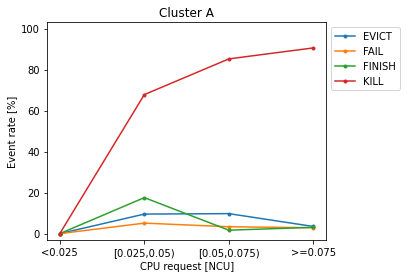

    term      interval     count
0      4        <0.025  0.000000
1      4       >=0.075  0.119310
2      4  [0.025,0.05)  0.096360
3      4  [0.05,0.075)  0.052641
4      5        <0.025  0.000000
5      5       >=0.075  0.021589
6      5  [0.025,0.05)  0.052500
7      5  [0.05,0.075)  0.005905
8      6        <0.025  0.000000
9      6       >=0.075  0.015289
10     6  [0.025,0.05)  0.154308
11     6  [0.05,0.075)  0.657504
12     7        <0.025  0.000000
13     7       >=0.075  0.843813
14     7  [0.025,0.05)  0.696833
15     7  [0.05,0.075)  0.283950


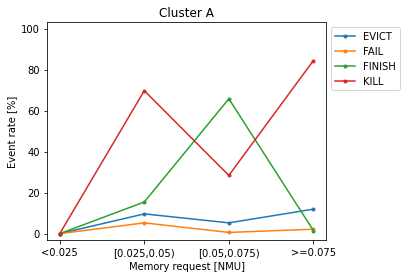

    term   interval     count
0      4       <0.2  0.204936
1      4        >=1  0.204259
2      4  [0.2,0.4)  0.280239
3      4  [0.4,0.6)  0.243188
4      4  [0.6,0.8)  0.213767
5      4    [0.8,1)  0.205417
6      5       <0.2  0.058212
7      5        >=1  0.045987
8      5  [0.2,0.4)  0.064447
9      5  [0.4,0.6)  0.062171
10     5  [0.6,0.8)  0.055319
11     5    [0.8,1)  0.051552
12     6       <0.2  0.228497
13     6        >=1  0.347004
14     6  [0.2,0.4)  0.144899
15     6  [0.4,0.6)  0.215167
16     6  [0.6,0.8)  0.269766
17     6    [0.8,1)  0.314757
18     7       <0.2  0.508356
19     7        >=1  0.402750
20     7  [0.2,0.4)  0.510416
21     7  [0.4,0.6)  0.479475
22     7  [0.6,0.8)  0.461149
23     7    [0.8,1)  0.428274


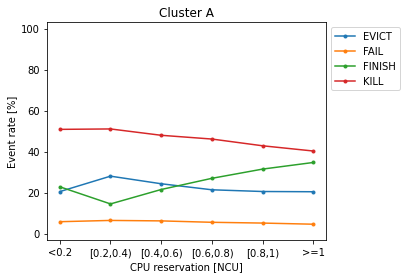

    term   interval     count
0      4       <0.2  0.204936
1      4        >=1  0.165210
2      4  [0.2,0.4)  0.239466
3      4  [0.4,0.6)  0.228508
4      4  [0.6,0.8)  0.188827
5      4    [0.8,1)  0.160894
6      5       <0.2  0.058212
7      5        >=1  0.037751
8      5  [0.2,0.4)  0.073245
9      5  [0.4,0.6)  0.064343
10     5  [0.6,0.8)  0.052677
11     5    [0.8,1)  0.041929
12     6       <0.2  0.228497
13     6        >=1  0.482098
14     6  [0.2,0.4)  0.143800
15     6  [0.4,0.6)  0.215247
16     6  [0.6,0.8)  0.333230
17     6    [0.8,1)  0.467823
18     7       <0.2  0.508356
19     7        >=1  0.314941
20     7  [0.2,0.4)  0.543490
21     7  [0.4,0.6)  0.491902
22     7  [0.6,0.8)  0.425266
23     7    [0.8,1)  0.329354


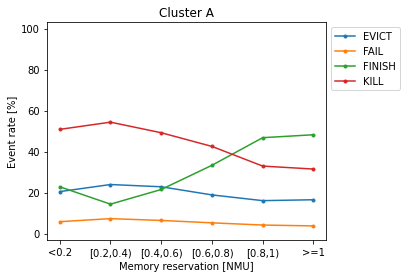

    term   interval     count
0      4       <0.2  0.095017
1      4        >=1  0.042735
2      4  [0.2,0.4)  0.017634
3      4  [0.4,0.6)  0.001944
4      4  [0.6,0.8)  0.008328
5      4    [0.8,1)  0.015936
6      5       <0.2  0.050756
7      5        >=1  0.094017
8      5  [0.2,0.4)  0.008651
9      5  [0.4,0.6)  0.003042
10     5  [0.6,0.8)  0.014734
11     5    [0.8,1)  0.039841
12     6       <0.2  0.170910
13     6        >=1  0.307692
14     6  [0.2,0.4)  0.023777
15     6  [0.4,0.6)  0.005831
16     6  [0.6,0.8)  0.008969
17     6    [0.8,1)  0.035857
18     7       <0.2  0.683317
19     7        >=1  0.555556
20     7  [0.2,0.4)  0.949938
21     7  [0.4,0.6)  0.989183
22     7  [0.6,0.8)  0.967969
23     7    [0.8,1)  0.908367


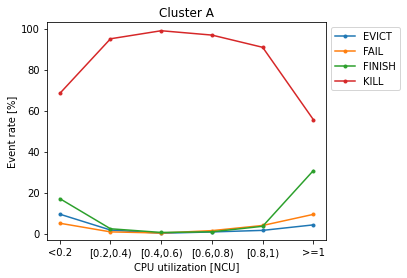

    term   interval     count
0      4       <0.2  0.094982
1      4        >=1  0.000000
2      4  [0.2,0.4)  0.047504
3      4  [0.4,0.6)  0.027027
4      4  [0.6,0.8)  0.000000
5      4    [0.8,1)  0.000000
6      5       <0.2  0.050737
7      5        >=1  0.000000
8      5  [0.2,0.4)  0.042745
9      5  [0.4,0.6)  0.117838
10     5  [0.6,0.8)  0.000000
11     5    [0.8,1)  1.000000
12     6       <0.2  0.170839
13     6        >=1  0.000000
14     6  [0.2,0.4)  0.240274
15     6  [0.4,0.6)  0.734054
16     6  [0.6,0.8)  0.991453
17     6    [0.8,1)  0.000000
18     7       <0.2  0.683442
19     7        >=1  0.000000
20     7  [0.2,0.4)  0.669477
21     7  [0.4,0.6)  0.121081
22     7  [0.6,0.8)  0.008547
23     7    [0.8,1)  0.000000


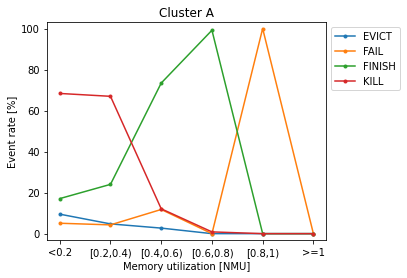

    term      interval     count
0      4        <0.025  0.000000
1      4       >=0.075  0.010560
2      4  [0.025,0.05)  0.063749
3      4  [0.05,0.075)  0.025979
4      5        <0.025  0.000000
5      5       >=0.075  0.015929
6      5  [0.025,0.05)  0.005648
7      5  [0.05,0.075)  0.027476
8      6        <0.025  0.000000
9      6       >=0.075  0.056526
10     6  [0.025,0.05)  0.071749
11     6  [0.05,0.075)  0.035046
12     7        <0.025  0.000000
13     7       >=0.075  0.916984
14     7  [0.025,0.05)  0.858854
15     7  [0.05,0.075)  0.911499


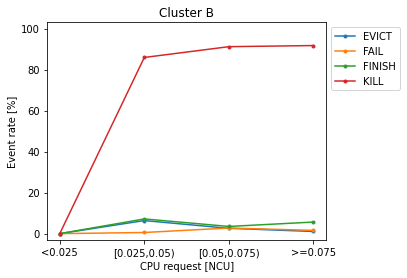

    term      interval     count
0      4        <0.025  0.000000
1      4       >=0.075  0.011622
2      4  [0.025,0.05)  0.063079
3      4  [0.05,0.075)  0.002371
4      5        <0.025  0.000000
5      5       >=0.075  0.019831
6      5  [0.025,0.05)  0.006679
7      5  [0.05,0.075)  0.003832
8      6        <0.025  0.000000
9      6       >=0.075  0.254700
10     6  [0.025,0.05)  0.062970
11     6  [0.05,0.075)  0.344004
12     7        <0.025  0.000000
13     7       >=0.075  0.713847
14     7  [0.025,0.05)  0.867271
15     7  [0.05,0.075)  0.649793


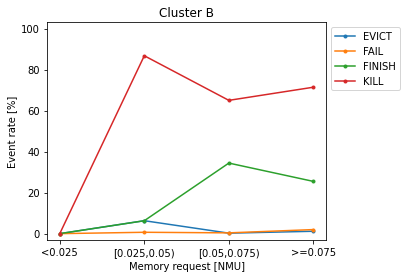

    term   interval     count
0      4       <0.2  0.484178
1      4        >=1  0.033715
2      4  [0.2,0.4)  0.018396
3      4  [0.4,0.6)  0.020030
4      4  [0.6,0.8)  0.024413
5      4    [0.8,1)  0.028645
6      5       <0.2  0.002669
7      5        >=1  0.006702
8      5  [0.2,0.4)  0.003091
9      5  [0.4,0.6)  0.003969
10     5  [0.6,0.8)  0.004933
11     5    [0.8,1)  0.005798
12     6       <0.2  0.510103
13     6        >=1  0.859634
14     6  [0.2,0.4)  0.923506
15     6  [0.4,0.6)  0.914358
16     6  [0.6,0.8)  0.898182
17     6    [0.8,1)  0.879677
18     7       <0.2  0.003050
19     7        >=1  0.099949
20     7  [0.2,0.4)  0.055007
21     7  [0.4,0.6)  0.061643
22     7  [0.6,0.8)  0.072472
23     7    [0.8,1)  0.085880


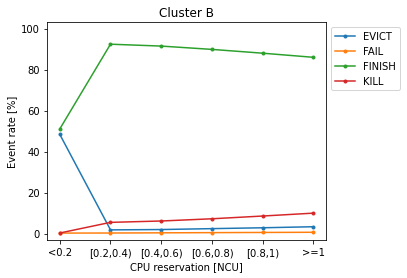

    term   interval     count
0      4       <0.2  0.484178
1      4        >=1  0.031792
2      4  [0.2,0.4)  0.018807
3      4  [0.4,0.6)  0.020889
4      4  [0.6,0.8)  0.024126
5      4    [0.8,1)  0.027791
6      5       <0.2  0.002669
7      5        >=1  0.005866
8      5  [0.2,0.4)  0.002855
9      5  [0.4,0.6)  0.003576
10     5  [0.6,0.8)  0.004402
11     5    [0.8,1)  0.005247
12     6       <0.2  0.510103
13     6        >=1  0.864200
14     6  [0.2,0.4)  0.924062
15     6  [0.4,0.6)  0.911879
16     6  [0.6,0.8)  0.896663
17     6    [0.8,1)  0.880848
18     7       <0.2  0.003050
19     7        >=1  0.098142
20     7  [0.2,0.4)  0.054276
21     7  [0.4,0.6)  0.063656
22     7  [0.6,0.8)  0.074809
23     7    [0.8,1)  0.086115


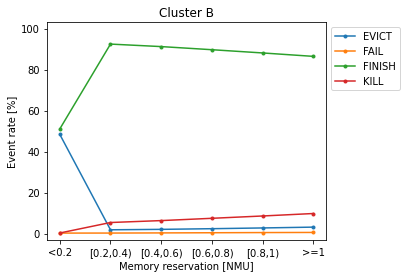

    term   interval     count
0      4       <0.2  0.061518
1      4        >=1  0.021767
2      4  [0.2,0.4)  0.003318
3      4  [0.4,0.6)  0.000737
4      4  [0.6,0.8)  0.002505
5      4    [0.8,1)  0.016427
6      5       <0.2  0.006661
7      5        >=1  0.267606
8      5  [0.2,0.4)  0.004625
9      5  [0.4,0.6)  0.002637
10     5  [0.6,0.8)  0.005636
11     5    [0.8,1)  0.032854
12     6       <0.2  0.070059
13     6        >=1  0.407170
14     6  [0.2,0.4)  0.122830
15     6  [0.4,0.6)  0.341025
16     6  [0.6,0.8)  0.351284
17     6    [0.8,1)  0.451745
18     7       <0.2  0.861761
19     7        >=1  0.303457
20     7  [0.2,0.4)  0.869227
21     7  [0.4,0.6)  0.655600
22     7  [0.6,0.8)  0.640576
23     7    [0.8,1)  0.498973


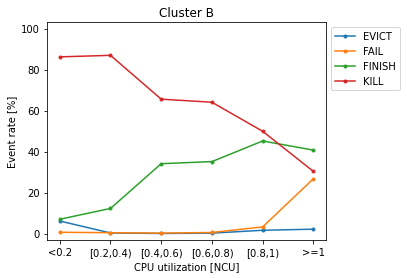

    term   interval     count
0      4       <0.2  0.061511
1      4        >=1  0.000000
2      4  [0.2,0.4)  0.002478
3      4  [0.4,0.6)  0.012262
4      4  [0.6,0.8)  0.000000
5      4    [0.8,1)  0.000000
6      5       <0.2  0.006661
7      5        >=1  0.000000
8      5  [0.2,0.4)  0.003745
9      5  [0.4,0.6)  0.006812
10     5  [0.6,0.8)  0.052632
11     5    [0.8,1)  0.250000
12     6       <0.2  0.070073
13     6        >=1  0.000000
14     6  [0.2,0.4)  0.146582
15     6  [0.4,0.6)  0.294278
16     6  [0.6,0.8)  0.000000
17     6    [0.8,1)  0.000000
18     7       <0.2  0.861756
19     7        >=1  0.000000
20     7  [0.2,0.4)  0.847195
21     7  [0.4,0.6)  0.686649
22     7  [0.6,0.8)  0.947368
23     7    [0.8,1)  0.750000


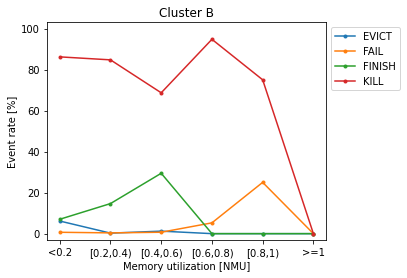

    term      interval     count
0      4        <0.025  0.000000
1      4       >=0.075  0.029742
2      4  [0.025,0.05)  0.047295
3      4  [0.05,0.075)  0.009998
4      5        <0.025  0.000000
5      5       >=0.075  0.037111
6      5  [0.025,0.05)  0.029460
7      5  [0.05,0.075)  0.035456
8      6        <0.025  0.000000
9      6       >=0.075  0.025731
10     6  [0.025,0.05)  0.070144
11     6  [0.05,0.075)  0.002510
12     7        <0.025  0.000000
13     7       >=0.075  0.907416
14     7  [0.025,0.05)  0.853101
15     7  [0.05,0.075)  0.952035


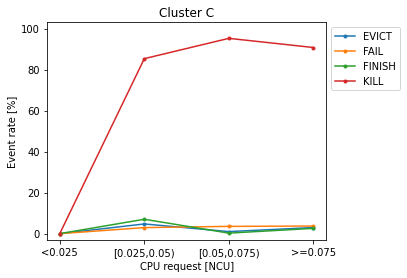

    term      interval     count
0      4        <0.025  0.000000
1      4       >=0.075  0.001346
2      4  [0.025,0.05)  0.047113
3      4  [0.05,0.075)  0.002540
4      5        <0.025  0.000000
5      5       >=0.075  0.001198
6      5  [0.025,0.05)  0.031890
7      5  [0.05,0.075)  0.003751
8      6        <0.025  0.000000
9      6       >=0.075  0.006335
10     6  [0.025,0.05)  0.059349
11     6  [0.05,0.075)  0.213957
12     7        <0.025  0.000000
13     7       >=0.075  0.991121
14     7  [0.025,0.05)  0.861648
15     7  [0.05,0.075)  0.779752


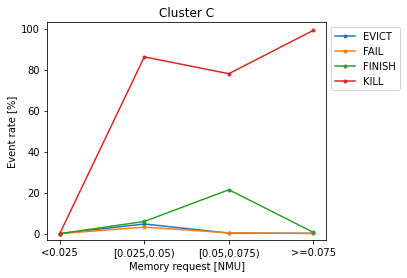

    term   interval     count
0      4       <0.2  0.044215
1      4        >=1  0.243542
2      4  [0.2,0.4)  0.007127
3      4  [0.4,0.6)  0.001332
4      4  [0.6,0.8)  0.004004
5      4    [0.8,1)  0.007267
6      5       <0.2  0.030016
7      5        >=1  0.228782
8      5  [0.2,0.4)  0.008684
9      5  [0.4,0.6)  0.001476
10     5  [0.6,0.8)  0.010919
11     5    [0.8,1)  0.021802
12     6       <0.2  0.064417
13     6        >=1  0.073801
14     6  [0.2,0.4)  0.049155
15     6  [0.4,0.6)  0.004202
16     6  [0.6,0.8)  0.006005
17     6    [0.8,1)  0.014535
18     7       <0.2  0.861351
19     7        >=1  0.453875
20     7  [0.2,0.4)  0.935034
21     7  [0.4,0.6)  0.992990
22     7  [0.6,0.8)  0.979072
23     7    [0.8,1)  0.956395


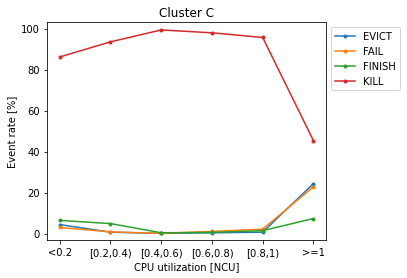

    term   interval     count
0      4       <0.2  0.044209
1      4        >=1  0.000000
2      4  [0.2,0.4)  0.002618
3      4  [0.4,0.6)  0.001380
4      4  [0.6,0.8)  0.000000
5      4    [0.8,1)  0.000000
6      5       <0.2  0.030014
7      5        >=1  0.000000
8      5  [0.2,0.4)  0.002591
9      5  [0.4,0.6)  0.008795
10     5  [0.6,0.8)  0.014790
11     5    [0.8,1)  0.000000
12     6       <0.2  0.064434
13     6        >=1  0.000000
14     6  [0.2,0.4)  0.004604
15     6  [0.4,0.6)  0.002625
16     6  [0.6,0.8)  0.068200
17     6    [0.8,1)  0.000000
18     7       <0.2  0.861343
19     7        >=1  0.000000
20     7  [0.2,0.4)  0.990187
21     7  [0.4,0.6)  0.987199
22     7  [0.6,0.8)  0.917009
23     7    [0.8,1)  1.000000


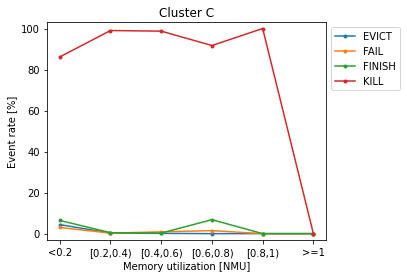

    term      interval     count
0      4        <0.025  0.000000
1      4       >=0.075  0.029307
2      4  [0.025,0.05)  0.053770
3      4  [0.05,0.075)  0.029428
4      5        <0.025  0.000000
5      5       >=0.075  0.106184
6      5  [0.025,0.05)  0.011875
7      5  [0.05,0.075)  0.033198
8      6        <0.025  0.000000
9      6       >=0.075  0.025815
10     6  [0.025,0.05)  0.152311
11     6  [0.05,0.075)  0.011892
12     7        <0.025  0.000000
13     7       >=0.075  0.838694
14     7  [0.025,0.05)  0.782044
15     7  [0.05,0.075)  0.925483


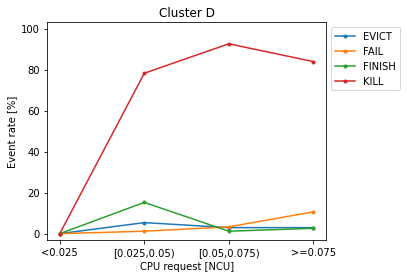

    term      interval     count
0      4        <0.025  0.000000
1      4       >=0.075  0.003620
2      4  [0.025,0.05)  0.056683
3      4  [0.05,0.075)  0.001973
4      5        <0.025  0.000000
5      5       >=0.075  0.017849
6      5  [0.025,0.05)  0.013247
7      5  [0.05,0.075)  0.008222
8      6        <0.025  0.000000
9      6       >=0.075  0.003230
10     6  [0.025,0.05)  0.128545
11     6  [0.05,0.075)  0.541109
12     7        <0.025  0.000000
13     7       >=0.075  0.975300
14     7  [0.025,0.05)  0.801525
15     7  [0.05,0.075)  0.448697


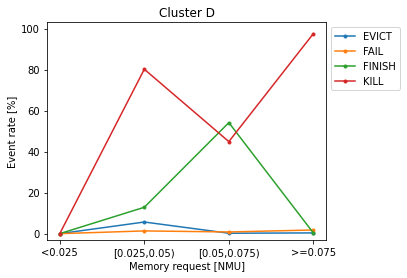

    term   interval     count
0      4       <0.2  0.052978
1      4        >=1  0.117318
2      4  [0.2,0.4)  0.031766
3      4  [0.4,0.6)  0.010123
4      4  [0.6,0.8)  0.019171
5      4    [0.8,1)  0.107492
6      5       <0.2  0.013065
7      5        >=1  0.634519
8      5  [0.2,0.4)  0.006756
9      5  [0.4,0.6)  0.013371
10     5  [0.6,0.8)  0.124894
11     5    [0.8,1)  0.530130
12     6       <0.2  0.147831
13     6        >=1  0.169656
14     6  [0.2,0.4)  0.034686
15     6  [0.4,0.6)  0.013352
16     6  [0.6,0.8)  0.014096
17     6    [0.8,1)  0.012215
18     7       <0.2  0.786126
19     7        >=1  0.078506
20     7  [0.2,0.4)  0.926792
21     7  [0.4,0.6)  0.963154
22     7  [0.6,0.8)  0.841838
23     7    [0.8,1)  0.350163


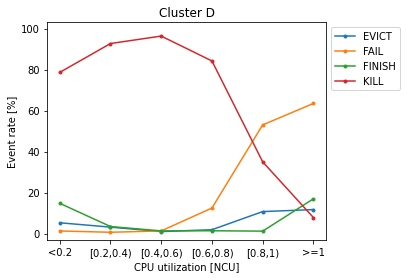

    term   interval     count
0      4       <0.2  0.052984
1      4        >=1  0.000000
2      4  [0.2,0.4)  0.011100
3      4  [0.4,0.6)  0.007429
4      4  [0.6,0.8)  0.039252
5      4    [0.8,1)  0.222222
6      5       <0.2  0.013068
7      5        >=1  0.000000
8      5  [0.2,0.4)  0.006068
9      5  [0.4,0.6)  0.004240
10     5  [0.6,0.8)  0.001869
11     5    [0.8,1)  0.111111
12     6       <0.2  0.147829
13     6        >=1  0.000000
14     6  [0.2,0.4)  0.008326
15     6  [0.4,0.6)  0.029831
16     6  [0.6,0.8)  0.000000
17     6    [0.8,1)  0.000000
18     7       <0.2  0.786120
19     7        >=1  0.000000
20     7  [0.2,0.4)  0.974507
21     7  [0.4,0.6)  0.958500
22     7  [0.6,0.8)  0.958879
23     7    [0.8,1)  0.666667


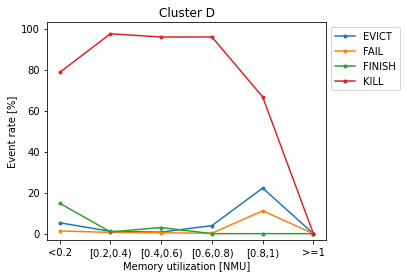

    term      interval     count
0      4        <0.025  0.000000
1      4       >=0.075  0.028977
2      4  [0.025,0.05)  0.014899
3      4  [0.05,0.075)  0.010970
4      5        <0.025  0.000000
5      5       >=0.075  0.035397
6      5  [0.025,0.05)  0.011481
7      5  [0.05,0.075)  0.008717
8      6        <0.025  0.000000
9      6       >=0.075  0.170067
10     6  [0.025,0.05)  0.007413
11     6  [0.05,0.075)  0.184418
12     7        <0.025  0.000000
13     7       >=0.075  0.765559
14     7  [0.025,0.05)  0.966207
15     7  [0.05,0.075)  0.795895


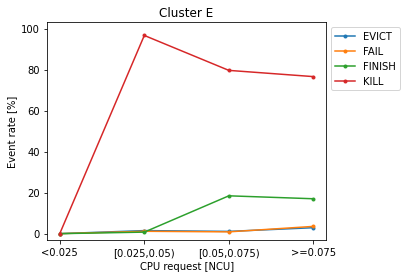

    term      interval     count
0      4        <0.025  0.000000
1      4       >=0.075  0.003031
2      4  [0.025,0.05)  0.015234
3      4  [0.05,0.075)  0.005270
4      5        <0.025  0.000000
5      5       >=0.075  0.002668
6      5  [0.025,0.05)  0.011374
7      5  [0.05,0.075)  0.038322
8      6        <0.025  0.000000
9      6       >=0.075  0.196690
10     6  [0.025,0.05)  0.019510
11     6  [0.05,0.075)  0.039520
12     7        <0.025  0.000000
13     7       >=0.075  0.797611
14     7  [0.025,0.05)  0.953881
15     7  [0.05,0.075)  0.916888


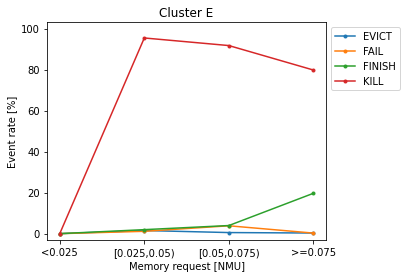

    term   interval     count
0      4       <0.2  0.010811
1      4        >=1  0.218224
2      4  [0.2,0.4)  0.246379
3      4  [0.4,0.6)  0.234563
4      4  [0.6,0.8)  0.229167
5      4    [0.8,1)  0.222852
6      5       <0.2  0.000000
7      5        >=1  0.029258
8      5  [0.2,0.4)  0.015034
9      5  [0.4,0.6)  0.015458
10     5  [0.6,0.8)  0.017386
11     5    [0.8,1)  0.027765
12     6       <0.2  0.765766
13     6        >=1  0.055720
14     6  [0.2,0.4)  0.021260
15     6  [0.4,0.6)  0.027401
16     6  [0.6,0.8)  0.035859
17     6    [0.8,1)  0.045272
18     7       <0.2  0.223423
19     7        >=1  0.696798
20     7  [0.2,0.4)  0.717326
21     7  [0.4,0.6)  0.722577
22     7  [0.6,0.8)  0.717588
23     7    [0.8,1)  0.704111


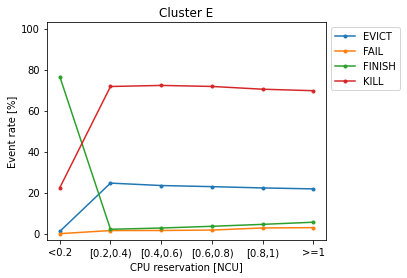

    term   interval     count
0      4       <0.2  0.010811
1      4        >=1  0.176043
2      4  [0.2,0.4)  0.220347
3      4  [0.4,0.6)  0.207082
4      4  [0.6,0.8)  0.198083
5      4    [0.8,1)  0.186599
6      5       <0.2  0.000000
7      5        >=1  0.033139
8      5  [0.2,0.4)  0.022097
9      5  [0.4,0.6)  0.025125
10     5  [0.6,0.8)  0.026569
11     5    [0.8,1)  0.031773
12     6       <0.2  0.765766
13     6        >=1  0.225855
14     6  [0.2,0.4)  0.083061
15     6  [0.4,0.6)  0.118644
16     6  [0.6,0.8)  0.155590
17     6    [0.8,1)  0.190720
18     7       <0.2  0.223423
19     7        >=1  0.564963
20     7  [0.2,0.4)  0.674495
21     7  [0.4,0.6)  0.649149
22     7  [0.6,0.8)  0.619759
23     7    [0.8,1)  0.590908


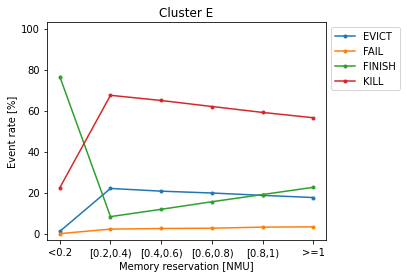

    term      interval     count
0      4        <0.025  0.000000
1      4       >=0.075  0.096662
2      4  [0.025,0.05)  0.067471
3      4  [0.05,0.075)  0.023231
4      5        <0.025  0.000000
5      5       >=0.075  0.020373
6      5  [0.025,0.05)  0.010190
7      5  [0.05,0.075)  0.012379
8      6        <0.025  0.000000
9      6       >=0.075  0.054822
10     6  [0.025,0.05)  0.066611
11     6  [0.05,0.075)  0.043860
12     7        <0.025  0.000000
13     7       >=0.075  0.828143
14     7  [0.025,0.05)  0.855727
15     7  [0.05,0.075)  0.920530


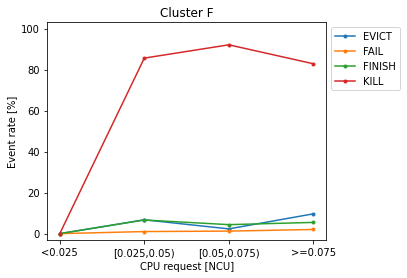

    term      interval     count
0      4        <0.025  0.000000
1      4       >=0.075  0.058221
2      4  [0.025,0.05)  0.066502
3      4  [0.05,0.075)  0.016463
4      5        <0.025  0.000000
5      5       >=0.075  0.003014
6      5  [0.025,0.05)  0.010755
7      5  [0.05,0.075)  0.007057
8      6        <0.025  0.000000
9      6       >=0.075  0.069035
10     6  [0.025,0.05)  0.057736
11     6  [0.05,0.075)  0.279824
12     7        <0.025  0.000000
13     7       >=0.075  0.869730
14     7  [0.025,0.05)  0.865007
15     7  [0.05,0.075)  0.696656


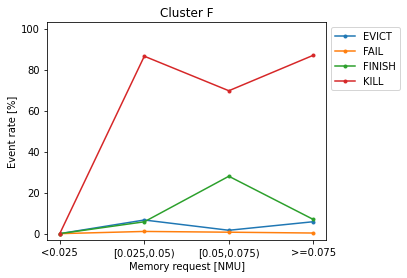

    term   interval     count
0      4       <0.2  0.398895
1      4        >=1  0.154125
2      4  [0.2,0.4)  0.149082
3      4  [0.4,0.6)  0.148567
4      4  [0.6,0.8)  0.151059
5      4    [0.8,1)  0.151352
6      5       <0.2  0.014917
7      5        >=1  0.055493
8      5  [0.2,0.4)  0.054390
9      5  [0.4,0.6)  0.054167
10     5  [0.6,0.8)  0.054299
11     5    [0.8,1)  0.054222
12     6       <0.2  0.477348
13     6        >=1  0.160638
14     6  [0.2,0.4)  0.147097
15     6  [0.4,0.6)  0.154194
16     6  [0.6,0.8)  0.157030
17     6    [0.8,1)  0.159054
18     7       <0.2  0.108840
19     7        >=1  0.629744
20     7  [0.2,0.4)  0.649432
21     7  [0.4,0.6)  0.643072
22     7  [0.6,0.8)  0.637612
23     7    [0.8,1)  0.635371


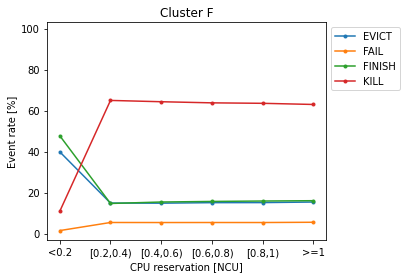

    term   interval     count
0      4       <0.2  0.398895
1      4        >=1  0.153082
2      4  [0.2,0.4)  0.153537
3      4  [0.4,0.6)  0.153362
4      4  [0.6,0.8)  0.153449
5      4    [0.8,1)  0.154420
6      5       <0.2  0.014917
7      5        >=1  0.053978
8      5  [0.2,0.4)  0.056889
9      5  [0.4,0.6)  0.054492
10     5  [0.6,0.8)  0.053878
11     5    [0.8,1)  0.054132
12     6       <0.2  0.477348
13     6        >=1  0.160185
14     6  [0.2,0.4)  0.146569
15     6  [0.4,0.6)  0.156027
16     6  [0.6,0.8)  0.159494
17     6    [0.8,1)  0.160445
18     7       <0.2  0.108840
19     7        >=1  0.632756
20     7  [0.2,0.4)  0.643006
21     7  [0.4,0.6)  0.636120
22     7  [0.6,0.8)  0.633179
23     7    [0.8,1)  0.631003


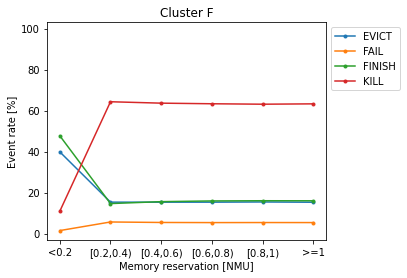

    term      interval     count
0      4        <0.025  0.000000
1      4       >=0.075  0.027186
2      4  [0.025,0.05)  0.035338
3      4  [0.05,0.075)  0.026020
4      5        <0.025  0.000000
5      5       >=0.075  0.004862
6      5  [0.025,0.05)  0.015667
7      5  [0.05,0.075)  0.005701
8      6        <0.025  0.000000
9      6       >=0.075  0.229969
10     6  [0.025,0.05)  0.252464
11     6  [0.05,0.075)  0.091298
12     7        <0.025  0.000000
13     7       >=0.075  0.737982
14     7  [0.025,0.05)  0.696531
15     7  [0.05,0.075)  0.876981


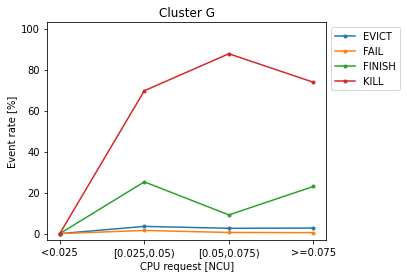

    term      interval     count
0      4        <0.025  0.000000
1      4       >=0.075  0.015596
2      4  [0.025,0.05)  0.036546
3      4  [0.05,0.075)  0.003716
4      5        <0.025  0.000000
5      5       >=0.075  0.153019
6      5  [0.025,0.05)  0.014370
7      5  [0.05,0.075)  0.022820
8      6        <0.025  0.000000
9      6       >=0.075  0.397037
10     6  [0.025,0.05)  0.225826
11     6  [0.05,0.075)  0.807378
12     7        <0.025  0.000000
13     7       >=0.075  0.434348
14     7  [0.025,0.05)  0.723258
15     7  [0.05,0.075)  0.166087


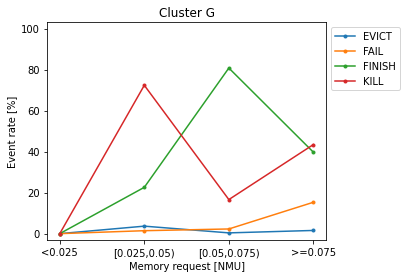

    term      interval     count
0      4        <0.025  0.000000
1      4       >=0.075  0.013170
2      4  [0.025,0.05)  0.007207
3      4  [0.05,0.075)  0.031299
4      5        <0.025  0.000000
5      5       >=0.075  0.020216
6      5  [0.025,0.05)  0.003397
7      5  [0.05,0.075)  0.002583
8      6        <0.025  0.000000
9      6       >=0.075  0.066252
10     6  [0.025,0.05)  0.054421
11     6  [0.05,0.075)  0.060496
12     7        <0.025  0.000000
13     7       >=0.075  0.900363
14     7  [0.025,0.05)  0.934976
15     7  [0.05,0.075)  0.905622


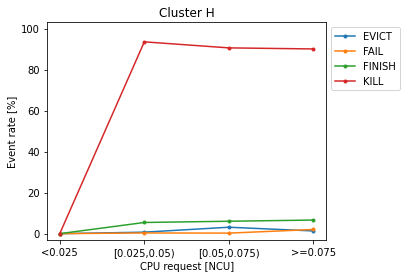

    term      interval     count
0      4        <0.025  0.000000
1      4       >=0.075  0.050038
2      4  [0.025,0.05)  0.008177
3      4  [0.05,0.075)  0.007631
4      5        <0.025  0.000000
5      5       >=0.075  0.002225
6      5  [0.025,0.05)  0.003356
7      5  [0.05,0.075)  0.019604
8      6        <0.025  0.000000
9      6       >=0.075  0.049023
10     6  [0.025,0.05)  0.045368
11     6  [0.05,0.075)  0.395468
12     7        <0.025  0.000000
13     7       >=0.075  0.898714
14     7  [0.025,0.05)  0.943099
15     7  [0.05,0.075)  0.577298


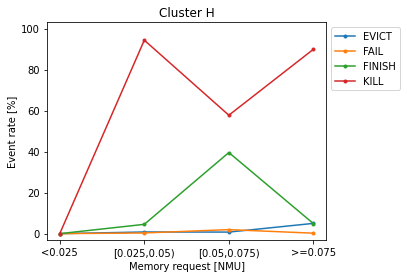

    term      interval     count
0      4        <0.025  0.000000
1      4       >=0.075  0.041204
2      4  [0.025,0.05)  0.044606
3      4  [0.05,0.075)  0.020170
4      5        <0.025  0.000000
5      5       >=0.075  0.028885
6      5  [0.025,0.05)  0.014656
7      5  [0.05,0.075)  0.019447
8      6        <0.025  0.000000
9      6       >=0.075  0.094778
10     6  [0.025,0.05)  0.090544
11     6  [0.05,0.075)  0.064682
12     7        <0.025  0.000000
13     7       >=0.075  0.835133
14     7  [0.025,0.05)  0.850194
15     7  [0.05,0.075)  0.895701


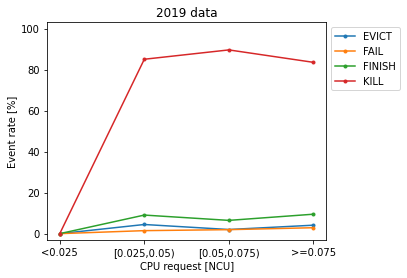

    term      interval     count
0      4        <0.025  0.000000
1      4       >=0.075  0.015998
2      4  [0.025,0.05)  0.044791
3      4  [0.05,0.075)  0.007652
4      5        <0.025  0.000000
5      5       >=0.075  0.015186
6      5  [0.025,0.05)  0.015187
7      5  [0.05,0.075)  0.012962
8      6        <0.025  0.000000
9      6       >=0.075  0.071583
10     6  [0.025,0.05)  0.079528
11     6  [0.05,0.075)  0.387294
12     7        <0.025  0.000000
13     7       >=0.075  0.897233
14     7  [0.025,0.05)  0.860495
15     7  [0.05,0.075)  0.592092


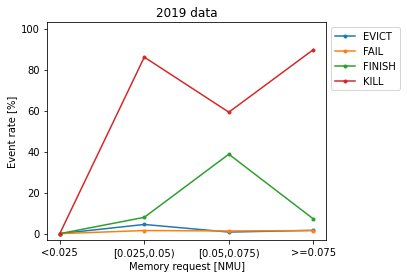

    term   interval     count
0      4       <0.2  0.205449
1      4        >=1  0.178661
2      4  [0.2,0.4)  0.209706
3      4  [0.4,0.6)  0.193886
4      4  [0.6,0.8)  0.181216
5      4    [0.8,1)  0.177358
6      5       <0.2  0.058041
7      5        >=1  0.040337
8      5  [0.2,0.4)  0.041928
9      5  [0.4,0.6)  0.042874
10     5  [0.6,0.8)  0.041236
11     5    [0.8,1)  0.042094
12     6       <0.2  0.229553
13     6        >=1  0.326669
14     6  [0.2,0.4)  0.218105
15     6  [0.4,0.6)  0.253870
16     6  [0.6,0.8)  0.281629
17     6    [0.8,1)  0.306586
18     7       <0.2  0.506957
19     7        >=1  0.454333
20     7  [0.2,0.4)  0.530260
21     7  [0.4,0.6)  0.509371
22     7  [0.6,0.8)  0.495919
23     7    [0.8,1)  0.473963


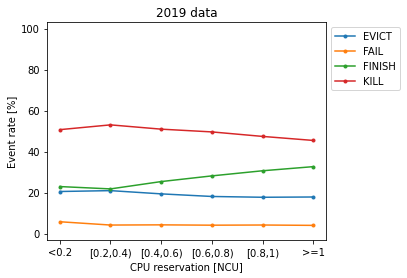

    term   interval     count
0      4       <0.2  0.205449
1      4        >=1  0.154111
2      4  [0.2,0.4)  0.189300
3      4  [0.4,0.6)  0.186162
4      4  [0.6,0.8)  0.167983
5      4    [0.8,1)  0.152814
6      5       <0.2  0.058041
7      5        >=1  0.036631
8      5  [0.2,0.4)  0.044335
9      5  [0.4,0.6)  0.045441
10     5  [0.6,0.8)  0.042147
11     5    [0.8,1)  0.038709
12     6       <0.2  0.229553
13     6        >=1  0.429169
14     6  [0.2,0.4)  0.216042
15     6  [0.4,0.6)  0.256060
16     6  [0.6,0.8)  0.322455
17     6    [0.8,1)  0.410903
18     7       <0.2  0.506957
19     7        >=1  0.380089
20     7  [0.2,0.4)  0.550323
21     7  [0.4,0.6)  0.512336
22     7  [0.6,0.8)  0.467415
23     7    [0.8,1)  0.397574


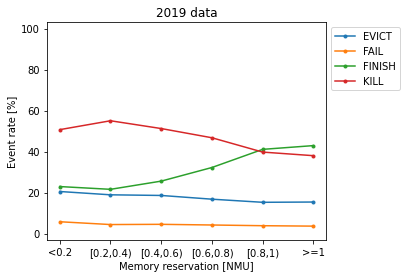

    term   interval     count
0      4       <0.2  0.056609
1      4        >=1  0.093087
2      4  [0.2,0.4)  0.014654
3      4  [0.4,0.6)  0.004608
4      4  [0.6,0.8)  0.007539
5      4    [0.8,1)  0.049984
6      5       <0.2  0.020233
7      5        >=1  0.486467
8      5  [0.2,0.4)  0.007748
9      5  [0.4,0.6)  0.006336
10     5  [0.6,0.8)  0.038662
11     5    [0.8,1)  0.225406
12     6       <0.2  0.097079
13     6        >=1  0.238661
14     6  [0.2,0.4)  0.049886
15     6  [0.4,0.6)  0.070199
16     6  [0.6,0.8)  0.172138
17     6    [0.8,1)  0.150907
18     7       <0.2  0.826078
19     7        >=1  0.181785
20     7  [0.2,0.4)  0.927712
21     7  [0.4,0.6)  0.918856
22     7  [0.6,0.8)  0.781661
23     7    [0.8,1)  0.573703


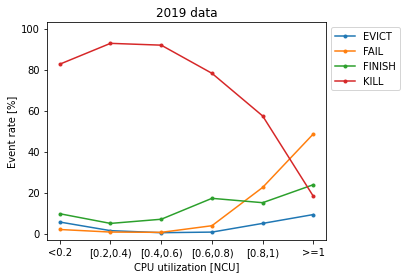

    term   interval     count
0      4       <0.2  0.056603
1      4        >=1  0.000000
2      4  [0.2,0.4)  0.006078
3      4  [0.4,0.6)  0.005267
4      4  [0.6,0.8)  0.014433
5      4    [0.8,1)  0.076923
6      5       <0.2  0.020233
7      5        >=1  0.000000
8      5  [0.2,0.4)  0.004193
9      5  [0.4,0.6)  0.007262
10     5  [0.6,0.8)  0.007560
11     5    [0.8,1)  0.153846
12     6       <0.2  0.097083
13     6        >=1  0.000000
14     6  [0.2,0.4)  0.012774
15     6  [0.4,0.6)  0.030206
16     6  [0.6,0.8)  0.227835
17     6    [0.8,1)  0.000000
18     7       <0.2  0.826081
19     7        >=1  0.000000
20     7  [0.2,0.4)  0.976956
21     7  [0.4,0.6)  0.957265
22     7  [0.6,0.8)  0.750172
23     7    [0.8,1)  0.769231


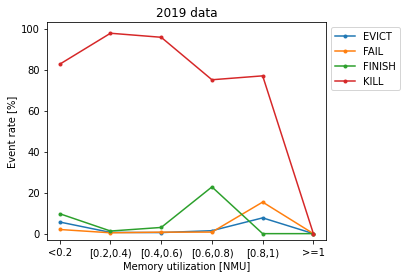

In [42]:
ab_bins = [(0, 0.025),
           (0.025, 0.05),
           (0.05, 0.075),
           (0.075, USICOST)]
cd_bins = [(0, 0.2),
           (0.2, 0.4),
           (0.4, 0.6),
           (0.6, 0.8),
           (0.8, 1),
           (1, USICOST)]
docd = "abef"
doef = "abcd"

for cluster in "abcdefgh":
    prepare_plot(cluster, "rcpu", ab_bins)
    prepare_plot(cluster, "rram", ab_bins)
    if cluster in docd:
        prepare_plot(cluster, "rscpu", cd_bins)
        prepare_plot(cluster, "rsram", cd_bins)
    if cluster in doef:
        prepare_plot(cluster, "ucpu", cd_bins)
        prepare_plot(cluster, "uram", cd_bins)
        
cluster = "all"
prepare_plot(cluster, "rcpu", ab_bins)
prepare_plot(cluster, "rram", ab_bins)
prepare_plot(cluster, "rscpu", cd_bins)
prepare_plot(cluster, "rsram", cd_bins)
prepare_plot(cluster, "ucpu", cd_bins)
prepare_plot(cluster, "uram", cd_bins)

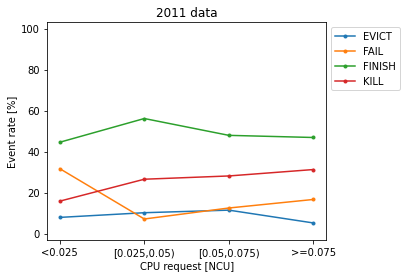

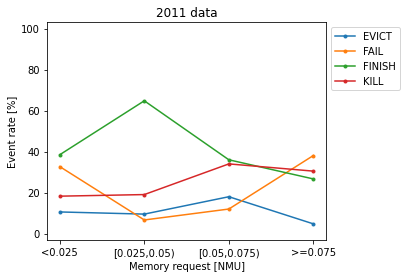

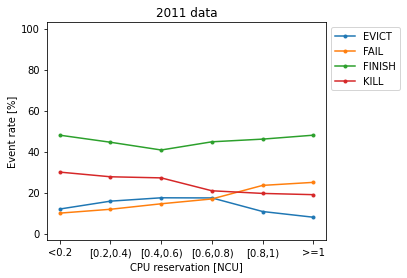

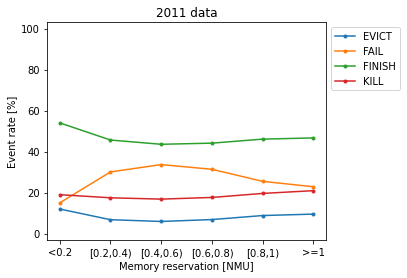

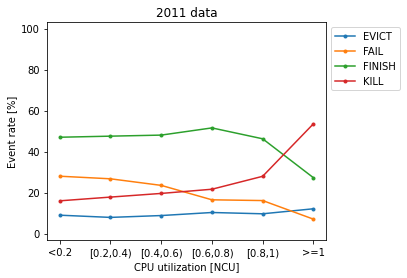

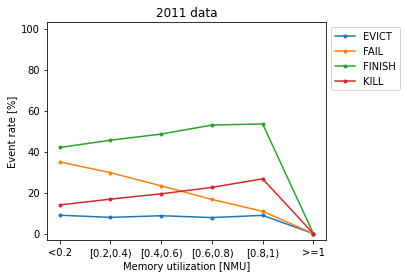

In [43]:

def malusa(l, r):
    return [a for a in itertools.chain(*[[b for x in range(r)] for b in l])]

def cdbhitcriasfm(measure, bins, data):
    dfa11 = {'term': [x for x in range(4,8)] * len(bins),
             'measure': [measure] * (len(bins) * 4),
             'interval': malusa([e[0] for e in bins], 4),
             'count': data}
    dfa11 = pd.DataFrame(data=dfa11, columns=dfa11.keys())
    prepare_plot("2011", measure, bins, dfa11)


cdbhitcriasfm("rcpu", ab_bins, 
    [8, 32, 45, 16,
     10, 7, 55, 26,
     11, 12, 46, 27,
     5, 16, 45, 30])
cdbhitcriasfm("rram", ab_bins, 
    [11, 34, 40, 19,
     10, 7, 68, 20,
     18, 12, 36, 34,
     5, 40, 28, 32])
cdbhitcriasfm("rscpu", cd_bins, 
    [12, 10, 48, 30,
     16, 12, 45, 28,
     18, 15, 42, 28,
     17.5, 17, 45, 21,
     11, 24, 47, 20, 
     8, 25, 48, 19])
cdbhitcriasfm("rsram", cd_bins, 
    [12, 15, 54, 19,
     7, 31, 47, 18,
     6, 34, 44, 17,
     7, 32, 45, 18,
     9, 26, 47, 20,
     10, 24, 49, 22])
cdbhitcriasfm("ucpu", cd_bins, 
    [9, 28, 47, 16,
     8, 27, 48, 18,
     9, 24, 49, 20,
     10, 16, 50, 21, 
     9, 15, 43, 26,
     12, 7, 27, 53])
cdbhitcriasfm("uram", cd_bins, 
    [9,35,42,14,
     8,30,46,17,
     9,24,50,20, 
     8,17,54,23,
     9,11,54,27,
     0,0,0,0])

#prepare_plot(cluster, "rram", ab_bins)
#prepare_plot(cluster, "rscpu", cd_bins)
#prepare_plot(cluster, "rsram", cd_bins)
#prepare_plot(cluster, "ucpu", cd_bins)
#prepare_plot(cluster, "uram", cd_bins)